# Naive Bayes Classifier - Implementation from scratch 
This notebook is an attempt to understand the mechanics of Naive Bayes Algorithm.
It contains 4 section:
- **Data Preparation** - Importing libraries and splitting the data in train test sets
- **Detailed implementation** of Naive Bayes - Step by step explanation but no efficient
- **Efficient implementation** of Naive Bayes - Focus on code efficiency
- **Sklearn implementation** - Comparing results with previous implementations. The comparision is done by only looking at the **confusion metrics**

# Importing Libraries & Data Preparation

### Importing required libraries

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import LabelBinarizer
import re
from matplotlib import pyplot as plt

### Importing the dataset
- This dataset contains 3000 movie reviews from IMDB website. The response variable captures if the review is positive or negative.
- The sample records of the dataset, and the category distribution is shown below.

In [2]:
inp_dataset = pd.read_csv("IMDB Imbalance.csv")
inp_dataset.head(2)

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive


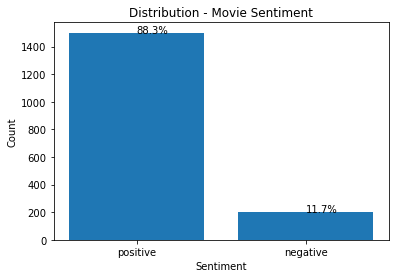

In [3]:
Cat_Count_df = inp_dataset.sentiment.value_counts().reset_index() 
Cat_Count_df["Percentage"] = Cat_Count_df["sentiment"]/Cat_Count_df["sentiment"].sum()*100
plt.bar(Cat_Count_df["index"], Cat_Count_df["sentiment"])
plt.xticks(Cat_Count_df["index"])
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.title("Distribution - Movie Sentiment")
for ind,row in Cat_Count_df.iterrows():
    plt.annotate(text=str(round(row["Percentage"],1))+"%",xy = (row["index"],row["sentiment"]))

plt.show()

### Cleaning the articles to remove the unwanted characters
- In this implementation, we are performing only basic data cleaning steps like removing numbers, punctuations and special characters and tags from text.
- This is done using regular expressions in the function defined as **text_clean**.
- Finally, we are splitting the data in to train and test set using *sklearn's function* **train_test_split**. The code is set to have 70% data in the training set.

In [33]:
def text_clean(text_series):
    text_series = text_series.str.lower()
    clean_2 = text_series.str.replace(r"<.*?>|[^a-zA-Z\s]"," ")
    clean_3 = clean_2.str.replace(r"\s[a-zA-Z]\s"," ")
    clean_4 = clean_3.str.replace(r"\s+", " ")
    return clean_4

In [34]:
inp_dataset["Text_Clean"] = text_clean(inp_dataset["review"])

In [39]:
train_x, test_x, train_y, test_y = train_test_split(inp_dataset["Text_Clean"], 
                                                    inp_dataset["sentiment"], 
                                                    test_size = 0.3, 
                                                    random_state = 8)

# BOW

In [40]:
Cnt_Vec_Model = CountVectorizer(stop_words="english")
train_x_array = Cnt_Vec_Model.fit_transform(train_x)
test_x_array = Cnt_Vec_Model.transform(test_x)
train_x_array = train_x_array.toarray()
test_x_array = test_x_array.toarray()

# Y Label Binarizer

In [46]:
Lbl_Bin_Model = LabelBinarizer()
train_y_array = Lbl_Bin_Model.fit_transform(train_y)
y_classes = Lbl_Bin_Model.classes_
if train_y_array.shape[1] == 1:
    train_y_array = np.concatenate([1-train_y_array,train_y_array], axis = 1)
cat_sum_array = train_y_array.sum(axis = 0)
cat_sum_array = cat_sum_array/cat_sum_array.sum()
cat_sum_array = np.log(cat_sum_array)

# Creating Train Array

In [356]:
train_array = np.dot(train_y_array.transpose(),train_x_array)
numerator_arrary = train_array + 1
denominator_array = numerator_arrary.sum(axis = 1)
probability_array = numerator_arrary/denominator_array.reshape(-1,1)
probability_array = np.log(probability_array)

# Prediction

In [80]:
Test_Prob_arr = np.dot(test_x_array,probability_array.transpose()) + cat_sum_array
prediction = y_classes[np.argmax(Test_Prob_arr,axis=1)]

In [81]:
pd.crosstab(prediction, test_y)

sentiment,negative,positive
row_0,,
negative,1,0
positive,58,451


# Improvement

In [376]:
new_probability_array = probability_array.copy()
new_probability_array[0] = np.where(probability_array[0]/probability_array[1] >= 1.2, probability_array[0], 0)
new_probability_array[1] = np.where(probability_array[0]/probability_array[1] <= .8, probability_array[1], 0)

# Prediction

In [377]:
Test_Prob_arr = np.dot(test_x_array,new_probability_array.transpose()) + cat_sum_array
prediction = y_classes[np.argmax(Test_Prob_arr,axis=1)]

In [378]:
pd.crosstab(prediction,test_y)

sentiment,negative,positive
row_0,,
negative,9,9
positive,50,442
